For the incoming climate data plot the line graph of air temperature against arrival time. You need to label some interesting points such as maximum and minimum values. 


<IPython.core.display.Javascript object>


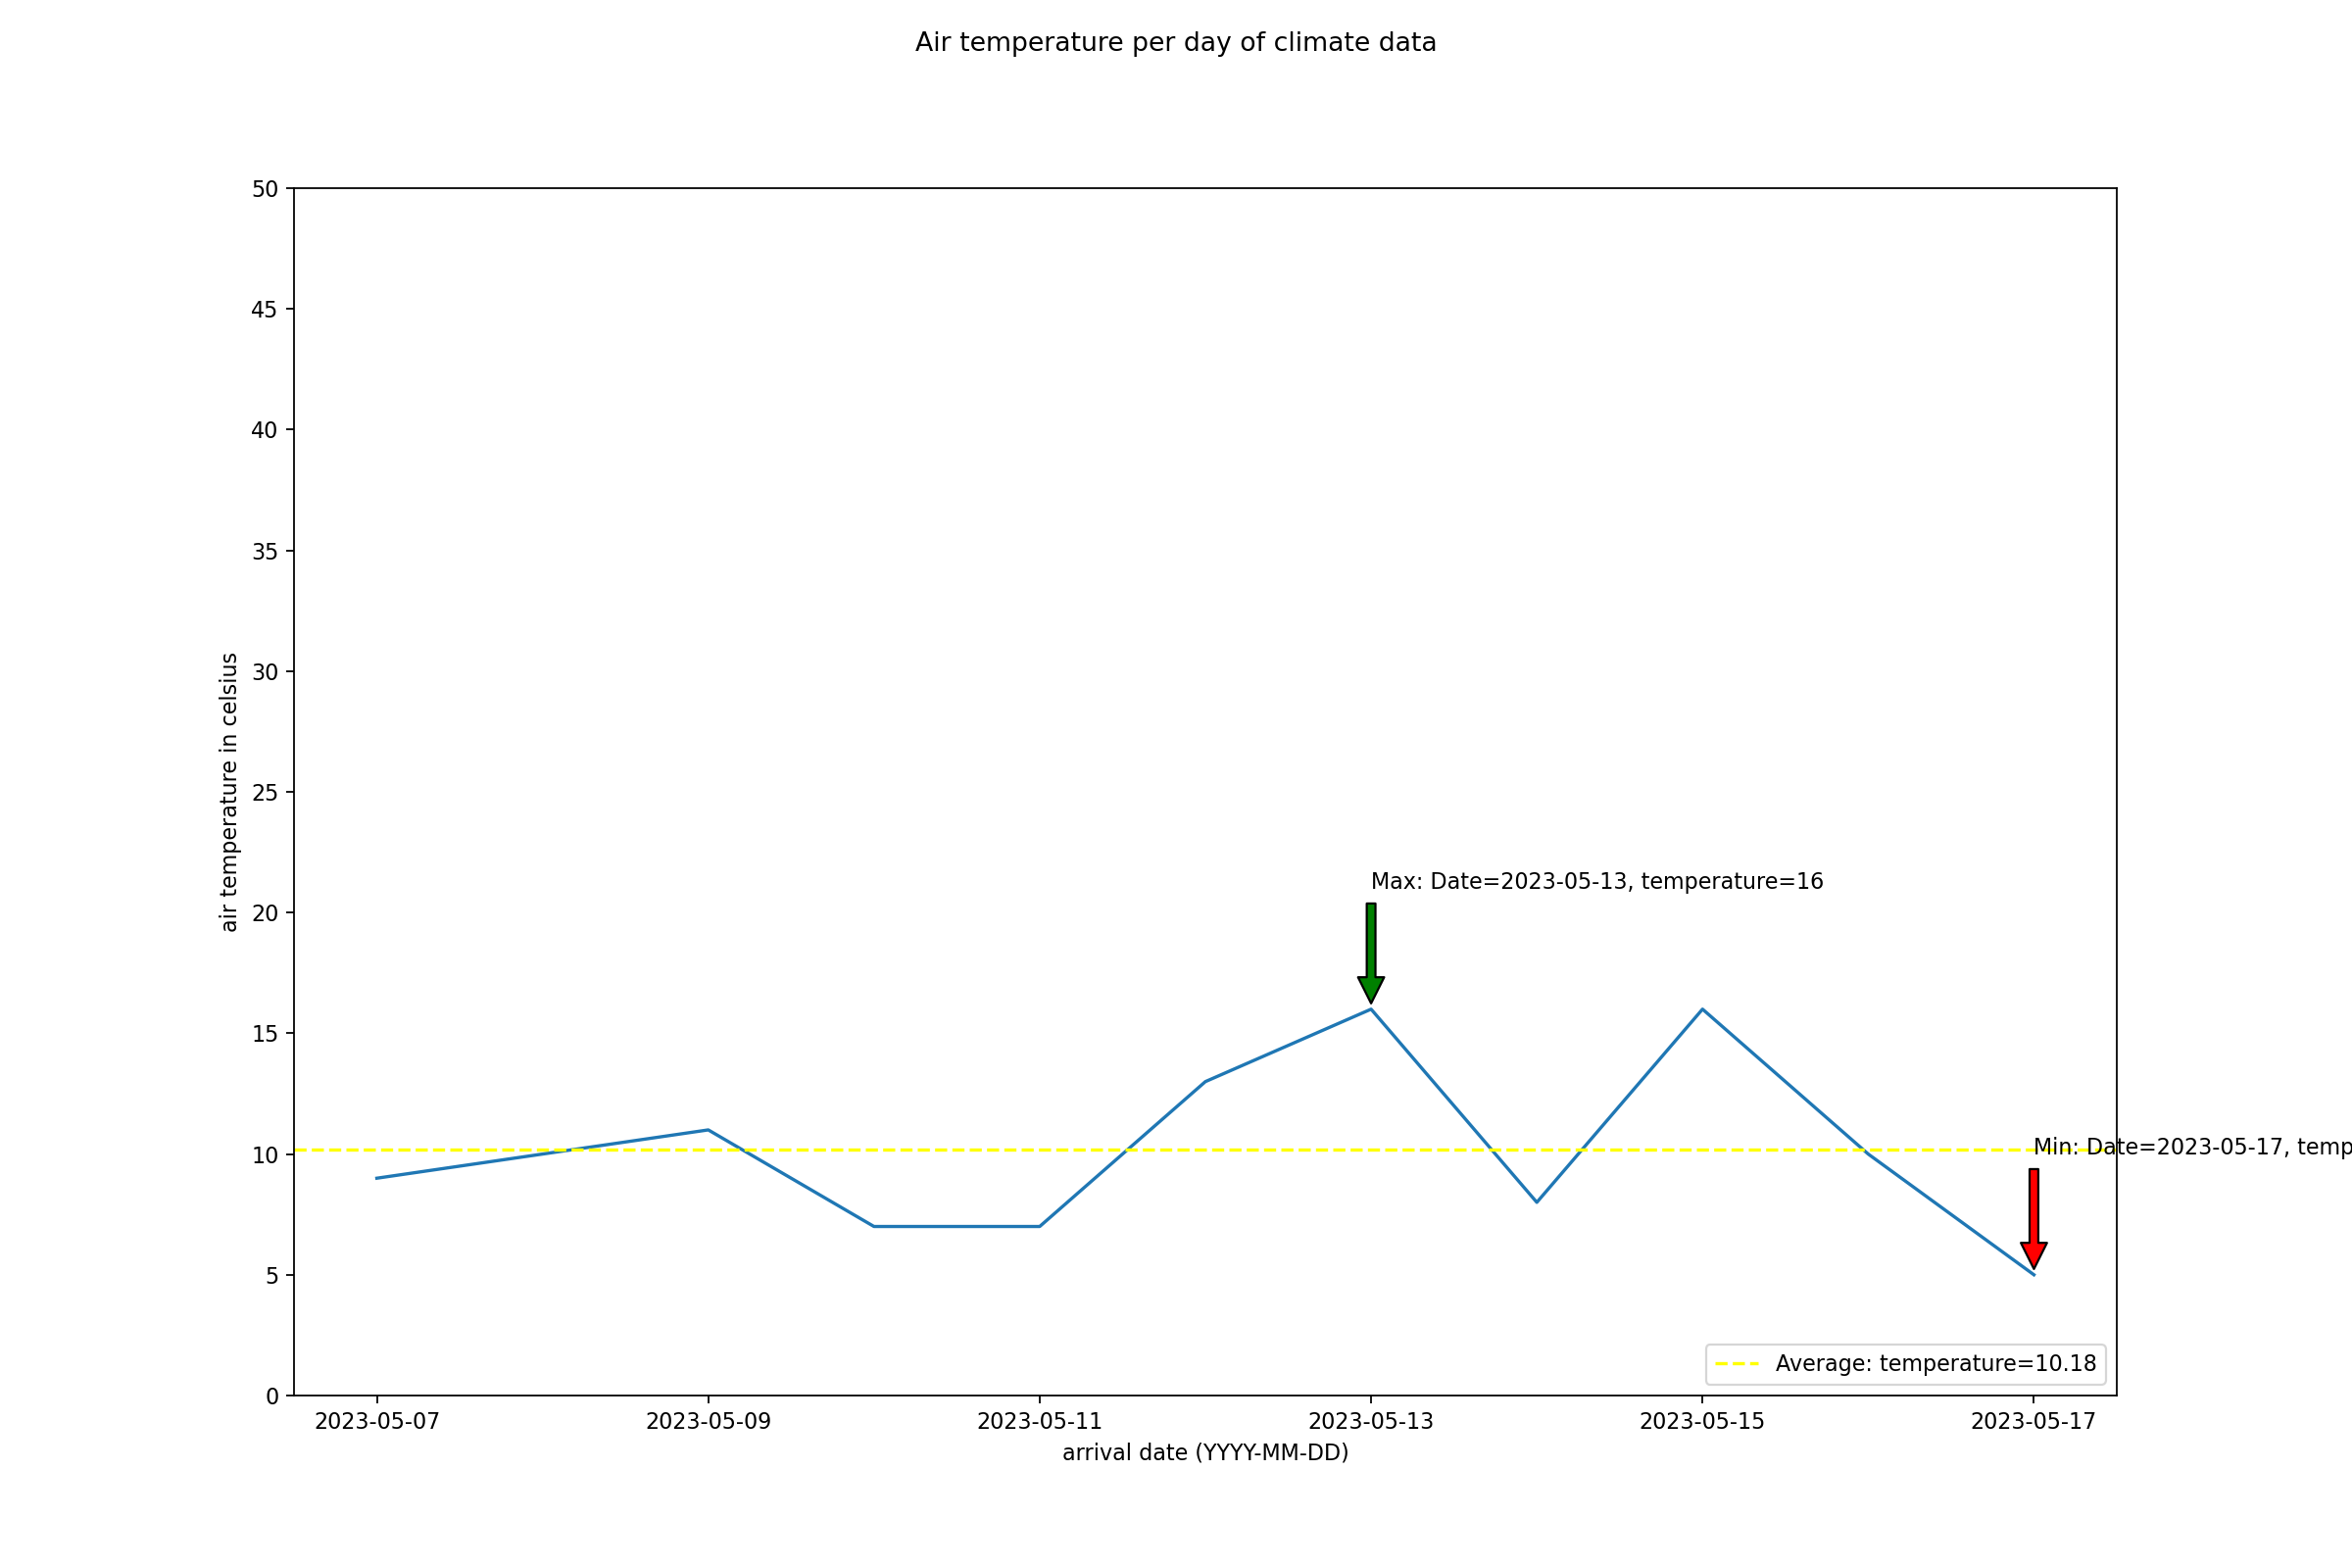

KeyboardInterrupt: 

In [83]:
# import statements
from kafka3 import KafkaConsumer
import datetime as dt
import statistics
import matplotlib.pyplot as plt
import statistics
import json 
from datetime import datetime
%matplotlib notebook

hostip = "192.168.0.108"
topic = 'Producer1'

"""
Plot maximum coordinate on line graph
"""
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Date={}, temperature={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='green', shrink=0.05),)

"""
Plot minimum coordinate on line graph
"""
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Date={}, temperature={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='red', shrink=0.05),)

"""
Plot average air temperature on line graph
"""
def annotate_avg(x, y, ax=None):
    yavg = statistics.mean(y)
    text = 'Average: temperature={:.2f}'.format(yavg)
    if not ax:
        ax = plt.gca()
    ax.axhline(y=yavg, color='yellow', linestyle='--', label=text)
    ax.legend(loc='lower right') #legend for average temperature

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=[f'{hostip}:9092'],
                                   value_deserializer=lambda m: json.loads(m.decode('utf-8')),
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer
    
def init_plot():
    try:
        width = 15
        height = 10
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('arrival time')
        ax1.set_ylabel('air temperature')        
        fig.suptitle('Air temperature per day of climate data') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax1
    except Exception as ex:
        print(str(ex))
        
def consume_message(consumer, fig, ax):
    try:
        x, y = [], []
        check = 0
        for message in consumer:
            data = message.value
            datetime_obj = datetime.fromisoformat(data['created_on'])
            air_temp = data['air_temperature_celcius']
            x.append(datetime_obj.date()) #add date part of datetime 
            y.append(air_temp)
            if len(y) > 10: 
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel("arrival date (YYYY-MM-DD)")
                ax.set_ylabel('air temperature in celsius')
                ax.set_yticks([0,5,10,15,20,25,30,35,40,45,50])
                annotate_max(x, y, ax)
                annotate_min(x, y, ax)
                annotate_avg(x,y, ax)
                fig.canvas.draw()
                x.pop(0)
                y.pop(0)
    except Exception as ex:
        print(str(ex))
        
if __name__ == '__main__':
    consumer =connect_kafka_consumer()
    fig, ax = init_plot()
    consume_message(consumer, fig, ax)
        

Plot a bar chart to visualise the total number of fire records based on each hour.


<IPython.core.display.Javascript object>


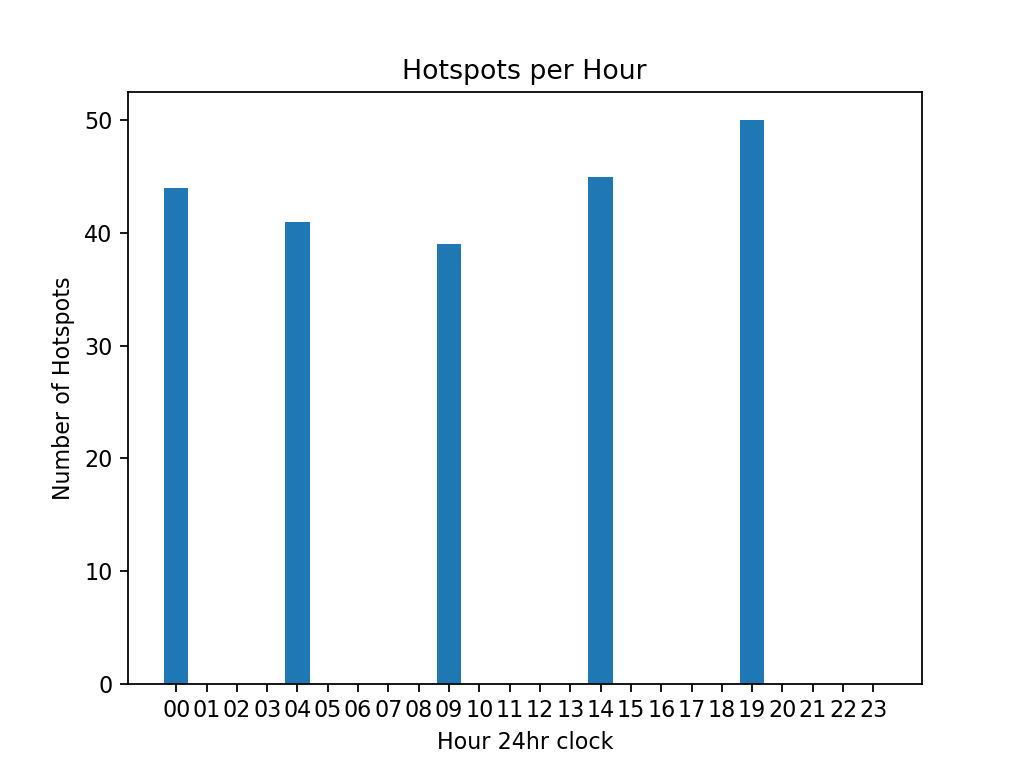

In [84]:
from pymongo import MongoClient
from kafka3 import KafkaConsumer
import datetime as dt
import statistics
import matplotlib.pyplot as plt
import statistics
import json 
from datetime import datetime
%matplotlib notebook
hostip = "192.168.0.108"

# Plot the bar chart
if __name__ == '__main__':
    client = MongoClient(hostip,27017)    
    db = client.fit3182_db
    hotspots = db.hotspots
    records= hotspots.find()

    hotspotCountPerHour={}
        
    # Iterate over the range of hours from 0 to 23
    for hour in range(24):
        hour_string = "{:02d}".format(hour)  # Format the hour as "HH:00"
        hotspotCountPerHour[hour_string] = 0  # Initialize the count for the hour to 0

    for hotspot in records:
        time = hotspot['datetime']
        hour_string = time.strftime('%H')
        hotspotCountPerHour[hour_string] = hotspotCountPerHour.get(hour_string, 0) + 1


    # Extract the hours and corresponding hotspot counts as separate lists
    hours = list(hotspotCountPerHour.keys())
    counts = list(hotspotCountPerHour.values())

    plt.bar(hours, counts)
    plt.xlabel('Hour 24hr clock')
    plt.ylabel('Number of Hotspots')
    plt.title('Hotspots per Hour')
    plt.show()
    client.close()


In a map visualise fire locations as markers. Use a ‘blue’ marker if the cause of the fire was ‘natural’. Otherwise, use a ‘red’ marker. Display detailed information such as air temperature, surface temperature, relative humidity,  and confidence with the marker tooltip. See the example below. You can use Folium for map visualisation.

In [90]:
import folium
from pymongo import MongoClient
from kafka3 import KafkaConsumer
import datetime as dt
import statistics
import matplotlib.pyplot as plt
import statistics
import json 
from datetime import datetime
from pymongo import MongoClient

%matplotlib notebook
hostip = "192.168.0.108"


client = MongoClient(hostip,27017)
db = client.fit3182_db
hotspots = db.hotspots
climate = db.climate

#perform pipeline aggregation on hotspot collection
#to peform join operation on climate collection to get air_temperature_celsius and relative humidity
pipeline = [
            {
                "$lookup": {
                    "from": "climate", 
                    "localField": "date",
                    "foreignField": "date",
                    "as": "climateData"
                }
            },
            {
                "$unwind": "$climateData"
            },
            {
                "$project": {
                    "_id": 0,
                    "time": { "$dateToString": { "format": "%H:%M:%S", "date": "$datetime" } },
                    "surface_temperature_celsius": 1,
                    "confidence": 1,
                    "latitude": 1,
                    "longitude": 1,
                    "air_temperature_celsius": "$climateData.air_temperature_celsius",
                    "relative_humidity": "$climateData.relative_humidity",
                    "type": 1,
                }
            }
        ]

result = hotspots.aggregate(pipeline)
avg_lat =0
avg_long = 0
result = list(result) #spread data into a list from an iterable

# find center coordinates of latitude and longitude
isFirstItr= True
for hotspot in result:
        if isFirstItr == True:
            avg_lat = hotspot['latitude']
            avg_long = hotspot['longitude']
            isFirstItr = False
        else:
            avg_lat = (hotspot['latitude'] + avg_lat) / 2
            avg_long = (hotspot['longitude'] + avg_long) / 2
    
#set the centre of the map to the center coordinate of all fires
fomap = folium.Map(location=[avg_lat, avg_long], zoom_start=8)

#add markers to the map
for hotspot in result:
        colorIcon = "red"
        if hotspot['type'] == "natural":
            colorIcon = "blue"
        
        folium.Marker(location=[float(hotspot['latitude']), float(hotspot['longitude'])], \
                     popup= """
                     air temperature: {} \n 
                     surface temperature: {} \n
                     relative humidity: {} \n
                     confidence: {} \n
                      """.format(hotspot['air_temperature_celsius'], 
                                 hotspot['surface_temperature_celsius'], 
                                 hotspot['relative_humidity'], 
                                 hotspot['confidence'] ), 
                     icon=folium.Icon(color=colorIcon),
                     tooltip=f"lat={str(hotspot['latitude'])}, \n lon={hotspot['longitude']}", \
                     ).add_to(fomap)      


client.close()




In [91]:
fomap